In [ ]:
 !pip install git+https://github.com/guillermo-jimenez/sak.git
!pip install timm
!pip install py-ecg-detectors
!pip install scikit-learn

  Cloning https://github.com/guillermo-jimenez/sak.git to /tmp/pip-req-build-reqaurlj
  Running command git clone --filter=blob:none --quiet https://github.com/guillermo-jimenez/sak.git /tmp/pip-req-build-reqaurlj
  Resolved https://github.com/guillermo-jimenez/sak.git to commit 90abd224fec256a81bf8304e44572af3bfdc4202
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2

In [ ]:
import pickle
import pandas as pd
import torch
import sak
from functools import partial
import math
import scipy as sp
from scipy.interpolate import interp1d
import skimage
import skimage.util
from typing import List,Tuple
import numpy as np
import timm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

# New Data Loading

In [ ]:
import pickle
from google.colab import drive
drive.mount('/content/Mydrive')

def load_dict_from_pickle(filename):
    with open(filename, 'rb') as file:
        data = pickle.load(file)
    return data

new_data = load_dict_from_pickle('/content/Mydrive/Shareddrives/Projecte_CompBioMed/CompBioMed2024_Seminars/train_data.pkl')

Mounted at /content/Mydrive


In [ ]:
new_data_test = load_dict_from_pickle('/content/Mydrive/Shareddrives/Projecte_CompBioMed/CompBioMed2024_Seminars/test_data.pkl')

In [ ]:
LVOT_places= ["RCC","COMMISURE","LVOTSUMMIT","LVOTSUBVALVULAR","LCC"]
RVOT_places = ["RVOTFREEWALL", "RVOTSEPTUM"]

r_or_l = []

for site in new_data['Simplified']:
  if site in LVOT_places:
    r_or_l.append(0)
  elif site in RVOT_places:
    r_or_l.append(1)
  else:
    r_or_l.append(-1)

new_data['tags'] = r_or_l

r_or_l_t = []

for site in new_data_test['Simplified']:
  if site in LVOT_places:
    r_or_l_t.append(0)
  elif site in RVOT_places:
    r_or_l_t.append(1)
  else:
    r_or_l_t.append(-1)

new_data_test['tags'] = r_or_l_t

del r_or_l_t
del r_or_l
del LVOT_places
del RVOT_places

In [ ]:
from ecgdetectors import Detectors

In [ ]:
def qrs_extraction(ecgs):
  fs = 1000
  fs_high,fs_low = 0.5,100.0
  detectors = Detectors(fs)

  tot = []
  for patient in ecgs: #180 patients
    tot.append(patient)

  r_tots =[]
  qrs = []
  for i in range(len(tot)):
    r_peaks = detectors.pan_tompkins_detector(tot[i])
    r_tots.append(r_peaks)
    r_pvc = min(r_peaks, key=lambda x: abs(x - 2000)) #sabem que a 2000 hi ha el pvc
    signal = sak.signal.interpolate.interp1d(tot[i],round(len(tot[i])), axis=0).T
    filtered_signal = sp.signal.filtfilt(*sp.signal.butter(2, fs_high/250, 'high'), signal, axis=-1)
    filtered_signal = sp.signal.filtfilt(*sp.signal.butter(2,  fs_low/250,  'low'), filtered_signal, axis=-1)
    # Extract the QRS segment
    start_idx = max(r_pvc - 150, 0)
    end_idx = min(r_pvc + 150, len(filtered_signal))
    qrs_seg = filtered_signal[start_idx:end_idx]

    if len(qrs_seg) != 300:
      x = np.linspace(0, len(qrs_seg) - 1, len(qrs_seg))
      f = interp1d(x, qrs_seg, kind='linear')
      x_new = np.linspace(0, len(qrs_seg) - 1, 300)
      qrs_seg = f(x_new)

    qrs.append(qrs_seg)

  return qrs


In [ ]:
new_data['qrs_v2'] = qrs_extraction(new_data['V2'])
new_data['qrs_v3'] = qrs_extraction(new_data['V3'])
new_data_test['qrs_v2'] = qrs_extraction(new_data_test['V2'])
new_data_test['qrs_v3'] = qrs_extraction(new_data_test['V3'])

In [ ]:
unb_data_df = pd.DataFrame(new_data) #we pass the dictionary to a dataframe
unb_data_df = unb_data_df.drop(unb_data_df[unb_data_df['tags'] == -1].index)
unb_data_df = unb_data_df.drop(unb_data_df[unb_data_df['PVC_transition'] == -1].index) #we filter the data for which the side is not defined
#training_data = data_df.drop(columns = ['Sex', 'HTA', 'Age', 'PVC_transition', 'SOO_chamber', 'Height', 'Weight', 'BMI', 'DM', 'DLP', 'Smoker', 'COPD', 'Sleep_apnea', 'CLINICAL_SCORE', 'SOO', 'OTorigin', 'Simplified', 'qrs'])

In [ ]:
import pandas as pd
unb_data_df = pd.DataFrame(new_data_test) #we pass the dictionary to a dataframe

In [ ]:
test_df = pd.DataFrame(new_data_test) #we pass the dictionary to a dataframe
test_df = test_df.drop(test_df[test_df['tags'] == -1].index)
test_df = test_df.drop(test_df[test_df['PVC_transition'] == -1].index) #we filter the data for which the side is not defined
#training_data = data_df.drop(columns = ['Sex', 'HTA', 'Age', 'PVC_transition', 'SOO_chamber', 'Height', 'Weight', 'BMI', 'DM', 'DLP', 'Smoker', 'COPD', 'Sleep_apnea', 'CLINICAL_SCORE', 'SOO', 'OTorigin', 'Simplified', 'qrs'])

In [ ]:
r_df = unb_data_df[unb_data_df['tags'] == 1]
right_size = r_df.shape[0]
l_df = unb_data_df[unb_data_df['tags'] == 0]
left_size = l_df.shape[0]
nsamples = min(r_df.shape[0], l_df.shape[0])
data_df = pd.concat([r_df.head(nsamples), l_df.head(nsamples)])
print('Balanced Data:')
print(f'--> Out of [{right_size}] right samples, {nsamples} were selected for training')
print(f'--> Out of [{left_size}] left samples, {nsamples} were selected for training')

Balanced Data:
--> Out of [207] right samples, 159 were selected for training
--> Out of [159] left samples, 159 were selected for training


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
concatenated_leads = [np.concatenate([v2, v3]) for v2, v3 in zip(data_df['qrs_v2'].values, data_df['qrs_v3'].values)]
leads_tensor_qrs_v2_v3 = torch.tensor(concatenated_leads).float().unsqueeze(1).permute(0, 2, 1).to(device)
tags_tensor = torch.tensor(data_df['tags'].values).unsqueeze(1).float().to(device)

<ipython-input-23-537ff518534e>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  leads_tensor_qrs_v2_v3 = torch.tensor(concatenated_leads).float().unsqueeze(1).permute(0, 2, 1).to(device)


In [ ]:
concatenated_leads_test = [np.concatenate([v2, v3]) for v2, v3 in zip(test_df['qrs_v2'].values, test_df['qrs_v3'].values)]
leads_tensor_qrs_v2_v3_test = torch.tensor(concatenated_leads_test).float().unsqueeze(1).permute(0, 2, 1).to(device)
tags_tensor_test = torch.tensor(test_df['tags'].values).unsqueeze(1).float().to(device)

# Model 3

In [ ]:
class SequenceClassifier(nn.Module):
  def __init__(self,
               input_size : int = 12,
               hidden_size : int = 5,
               num_layers = 1, matrix : bool = False,
               bidirectional : bool=False, ):
    # LSTM archgitecture to avoid exploding and/or vanishing gradient problems (most optimal as seen in deep learning course)
    super().__init__()
    self.rnn =  nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                        num_layers=num_layers, bidirectional = bidirectional, batch_first = True)
    self.sigmoid = nn.Sigmoid()
    self.last_linear = nn.Linear(hidden_size,1)
    self.matrix = matrix

  def forward(self, X):
    _,last_states = self.rnn(X)
    # Get last hidden state for last layer. Ignore cell state in case of LSTMs
    if self.matrix:
      last_hidden_state = last_states[0][-1,:,:].squeeze(0)
    else:
      last_hidden_state = last_states[0][-1,:].squeeze(0)

    # Get sequence label probability using the last hidden state
    output = self.sigmoid(self.last_linear(last_hidden_state))
    return output, last_hidden_state

In [ ]:
def test_sequence_classifier_in_test(Y_test, output, prob_threshold=0.5):
    # Convert output to a PyTorch tensor
    output_tensor = torch.tensor(output)

    # Convert probabilities to binary predictions based on the threshold
    predictions = (output_tensor > prob_threshold).float()

    # Convert Y_test to a PyTorch tensor
    Y_test_tensor = torch.tensor(Y_test)

    # Calculate accuracy
    accuracy = (predictions == Y_test_tensor).float().mean().item()

    return accuracy



In [ ]:
xtrafeatures = data_df[['Height','Weight', 'Age']]
mean_valuestest = xtrafeatures.mean(skipna=True)
xtrafeatures = xtrafeatures.fillna(mean_valuestest)
xtrafeatures = xtrafeatures[['Height','Weight', 'Age']].values
xtrafeatures = xtrafeatures.tolist()
xtrafeatures_tensor = torch.tensor(xtrafeatures).float().to(device)

In [ ]:
class BMLP(nn.Module):
    def __init__(self, input_size : int = 8, hidden_sizes = [8, 8]):
        super(BMLP, self).__init__()
        # Create layers based on the specified sizes
        layers = []
        sizes = [input_size] + hidden_sizes
        for i in range(len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1]))  # Fully connected layer
            if i < len(sizes) - 2:
                layers.append(nn.ReLU())  # Activation function (ReLU)

        layers.append(nn.Linear(sizes[-1], 1))
        layers.append(nn.Sigmoid())  # Sigmoid for probability output


        self.network = nn.Sequential(*layers)  # Sequential model with layers

    def forward(self, x):
        return self.network(x)

In [ ]:
def normalizet(tensor):
  min_vals = torch.min(tensor, dim=0).values  # Minimum of each feature
  max_vals = torch.max(tensor, dim=0).values  # Maximum of each feature
  normalized_tensor = (tensor - min_vals) / (max_vals - min_vals)
  return normalized_tensor

def train_seq_model3(leads_data_un, y_t, xtra_features, test_data_un, y_test, xtra_test, classifier, mlp, optimizer, optimizermlp, loss_func, loss_func_mlp, epochs=50, expanded = True):
  leads_data = normalizet(leads_data_un)
  test_data = normalizet(test_data_un)
  feats = []
  outputs = []
  trainlen = len(leads_data)
  losses = []
  lossmlp = []
  accuracies = []

  test_accuracies = []
  test_losses = []
  test_losses_mlp = []

  print('--------Initializing training')
  for iter in range(epochs):
    if iter%5 == 0: print(f'training epoch #{iter}')
    optimizer.zero_grad()

    out, emb = classifier(leads_data)
    test_out, emb_test = classifier(test_data)

    loss = loss_func(out, y_t)

    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    testloss = loss_func(test_out, y_test)
    test_losses.append(testloss.item())


  if expanded:
    combined_tensor = normalizet(torch.cat((emb.detach(), xtra_features), dim=1))
    print('expanded features')
  else:
    combined_tensor = normalizet(emb.detach())

  if expanded:
    combined_tensor_test = normalizet(torch.cat((emb_test.detach(), xtra_test), dim=1))
  else:
    combined_tensor_test = normalizet(emb_test.detach())

  print('-----------Training MLP')

  y_t = y_t.detach()
  y_test = y_test.detach()

  for iter in range(epochs):
    if iter%5 == 0: print(f'training epoch #{iter}')

    optimizermlp.zero_grad()

    outputotal = mlp(combined_tensor)
    outputotal_test = mlp(combined_tensor_test)

    losstot = loss_func_mlp(outputotal, y_t)
    losstot.backward()
    optimizermlp.step()
    lossmlp.append(losstot.item())
    accuracies.append(test_sequence_classifier_in_test(np.asarray(y_t.cpu().detach()), outputotal.cpu(), prob_threshold=0.5))

    losstot_test = loss_func_mlp(outputotal_test, y_test)
    test_losses_mlp.append(losstot_test.item())
    test_accuracies.append(test_sequence_classifier_in_test(np.asarray(y_test.detach().cpu()), outputotal_test.cpu(), prob_threshold=0.5))
#losses_m3_x, lossmlp_v2_x, points_v2_x, predictions_m3_x, accuracies_m3_x, test_losses_m3_x, test_accuracies_m3_x, test_output_ms_x
  return np.asarray(losses), np.asarray(lossmlp),emb.cpu(), np.asarray(outputotal.cpu().detach()), np.asarray(accuracies), np.asarray(test_losses), np.asarray(test_accuracies), np.asarray(outputotal_test.cpu().detach())

In [ ]:
xtrafeatures_test = test_df[['Height','Weight', 'Age']]
mean_valuestest_test = xtrafeatures_test.mean(skipna=True)
xtrafeatures_test = xtrafeatures_test.fillna(mean_valuestest_test)
xtrafeatures_test = xtrafeatures_test[['Height','Weight', 'Age']].values
xtrafeatures_test = xtrafeatures_test.tolist()
xtrafeatures_tensor_test = torch.tensor(xtrafeatures_test).float().to(device)

In [ ]:
lstmclassifier_m3_2 = SequenceClassifier(input_size=1, hidden_size = 5,matrix=True).to(device)
mlp_m3_2 = BMLP().to(device)

noptimizer_m3_2 = torch.optim.Adam(lstmclassifier_m3_2.parameters(), lr=5e-4)
noptimizer_m3_mlp_2 = torch.optim.Adam(mlp_m3_2.parameters(), lr=5e-4)

nloss_m3_seq_2 = nn.BCELoss()
nloss_m3_mlp_2 = nn.BCELoss()

################################################################leads_data_un, y_t, xtra_features, test_data, y_test, xtra_test, classifier, mlp, optimizer, optimizermlp, loss_func, loss_func_mlp, epochs=50

losses_m3_1, loss_mlp_m3_1 ,points_v2_v3_1, predictions_m3_1, accuracies_m3_1, test_losses_m3_1, test_accuracies_m3_1, output_test_m3_1  = train_seq_model3(leads_tensor_qrs_v2_v3, tags_tensor, xtrafeatures_tensor, leads_tensor_qrs_v2_v3_test, tags_tensor_test, xtrafeatures_tensor_test,lstmclassifier_m3_2, mlp_m3_2, noptimizer_m3_2, noptimizer_m3_mlp_2, nloss_m3_seq_2, nloss_m3_mlp_2, epochs=200)
points_array_m3 = np.asarray(points_v2_v3_1.detach())

--------Initializing training
training epoch #0
training epoch #5
training epoch #10
training epoch #15
training epoch #20
training epoch #25
training epoch #30
training epoch #35
training epoch #40
training epoch #45
training epoch #50
training epoch #55
training epoch #60
training epoch #65
training epoch #70
training epoch #75
training epoch #80
training epoch #85
training epoch #90
training epoch #95
training epoch #100
training epoch #105
training epoch #110
training epoch #115
training epoch #120
training epoch #125
training epoch #130
training epoch #135
training epoch #140
training epoch #145
training epoch #150
training epoch #155
training epoch #160
training epoch #165
training epoch #170
training epoch #175
training epoch #180
training epoch #185
training epoch #190
training epoch #195
expanded features
-----------Training MLP
training epoch #0
training epoch #5
training epoch #10
training epoch #15
training epoch #20
training epoch #25


<ipython-input-26-49e8a343d102>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output_tensor = torch.tensor(output)


training epoch #30
training epoch #35
training epoch #40
training epoch #45
training epoch #50
training epoch #55
training epoch #60
training epoch #65
training epoch #70
training epoch #75
training epoch #80
training epoch #85
training epoch #90
training epoch #95
training epoch #100
training epoch #105
training epoch #110
training epoch #115
training epoch #120
training epoch #125
training epoch #130
training epoch #135
training epoch #140
training epoch #145
training epoch #150
training epoch #155
training epoch #160
training epoch #165
training epoch #170
training epoch #175
training epoch #180
training epoch #185
training epoch #190
training epoch #195


In [ ]:
print(f'--> Final accuracy for training data:  {accuracies_m3_1[-1]}')
print(f'--> Final accuracy for testing data:   {test_accuracies_m3_1[-1]}')

--> Final accuracy for training data:  0.6761006116867065
--> Final accuracy for testing data:   0.6619718074798584


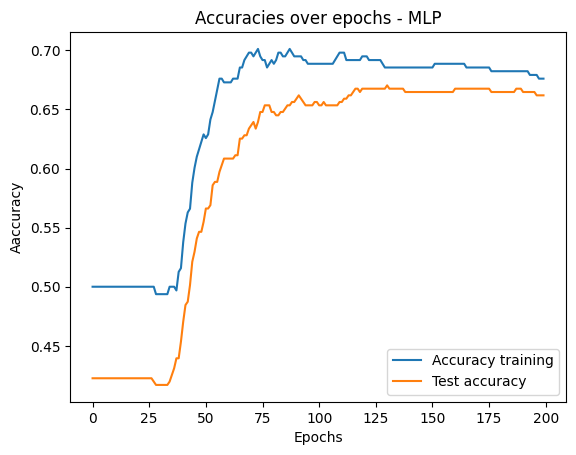

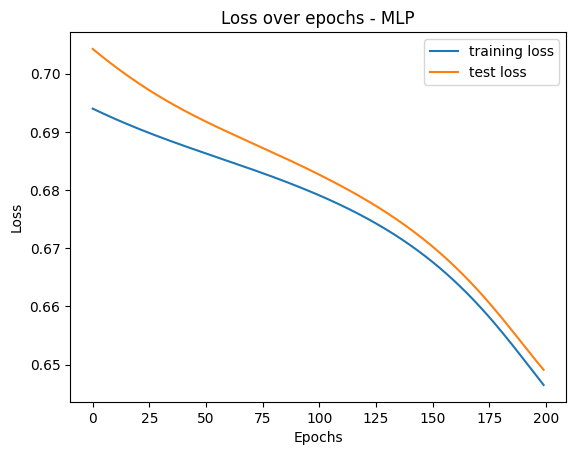

In [ ]:
plt.plot(accuracies_m3_1, label='Accuracy training')
plt.plot(test_accuracies_m3_1, label='Test accuracy')
plt.legend()
plt.title('Accuracies over epochs - MLP')
plt.xlabel('Epochs')
plt.ylabel('Aaccuracy')
plt.show()
plt.plot(losses_m3_1, label='training loss')
plt.plot(test_losses_m3_1, label='test loss')
plt.legend()
plt.title('Loss over epochs - MLP')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Balanced Training Data:
--> Out of [207] right samples, 159 were selected for training
--> Out of [159] right samples, 159 were selected for training


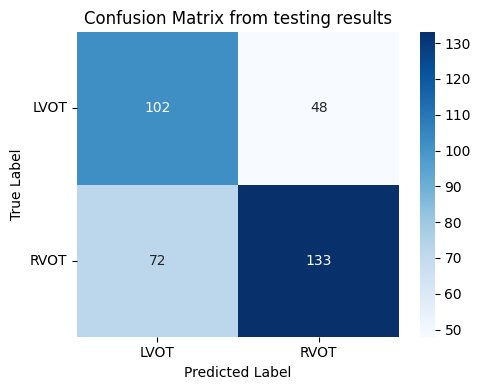

In [ ]:
output_array = (output_test_m3_1.squeeze(1) > 0.5).astype(int)
cm_m3_1 = confusion_matrix(np.asarray(tags_tensor_test.cpu()).squeeze(1).astype(int), output_array)

print('Balanced Training Data:')
print(f'--> Out of [{right_size}] right samples, {nsamples} were selected for training')
print(f'--> Out of [{left_size}] right samples, {nsamples} were selected for training')

# print('\nTesting Data (different from training):')
# print(f'--> {r_test_size} Right samples were selected for testing')
# print(f'--> {l_test_size} Left samples were selected for testing')

# Class names
class_names = ['LVOT', 'RVOT']

# Plotting the heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm_m3_1, annot=True, fmt='d', cmap='Blues')

# Adding labels and title
plt.xticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names)
plt.yticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names, rotation=0)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix from testing results')

# Adjusting the layout for better fit
plt.tight_layout()

# Show the plot
plt.show()


# Model 3 - Simultaneous

In [ ]:
def normalizet(tensor):
  min_vals = torch.min(tensor, dim=0).values  # Minimum of each feature
  max_vals = torch.max(tensor, dim=0).values  # Maximum of each feature
  normalized_tensor = (tensor - min_vals) / (max_vals - min_vals)
  return normalized_tensor

def train_seq_model3_2(leads_data_un, y_t, xtra_features, classifier, mlp, optimizer, optimizermlp, loss_func, loss_func_mlp, epochs=50):
  leads_data = normalizet(leads_data_un)
  feats = []
  outputs = []
  trainlen = len(leads_data)
  losses = []
  lossmlp = []

  print('--------Initializing training')
  for iter in range(epochs):
    if iter%5 == 0: print(f'training epoch #{iter}')
    optimizer.zero_grad()

    out, emb = classifier(leads_data)

    loss = loss_func(out, y_t)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

  combined_tensor = normalizet(torch.cat((emb.detach(), xtra_features), dim=1))

  print('-----------Training MLP')

  y_t = y_t.detach()

  for iter in range(epochs):
    if iter%5 == 0: print(f'training epoch #{iter}')

    optimizermlp.zero_grad()
    outputotal = mlp(combined_tensor)
    losstot = loss_func_mlp(outputotal, y_t)
    losstot.backward()
    optimizermlp.step()
    lossmlp.append(losstot.item())


  return np.asarray(losses), np.asarray(lossmlp),emb, np.asarray(outputotal.detach().cpu())

In [ ]:
qrs_lead_v2_v3 = data_df[['qrs_v2', 'qrs_v3']].values
patient_ECG_qrs_v2_v3 = qrs_lead_v2_v3.tolist()
leads_tensor_qrs_v2_v3_2 = torch.tensor(patient_ECG_qrs_v2_v3).permute(0,2,1).float().to(device)

In [ ]:
lstmclassifier_m3 = SequenceClassifier(input_size=2, hidden_size = 3,matrix=True).to(device)
mlp_m3 = BMLP(input_size = 6, hidden_sizes = [5, 5]).to(device)

noptimizer_m3 = torch.optim.Adam(lstmclassifier_m3.parameters(), lr=5e-4)
noptimizer_m3_mlp = torch.optim.Adam(mlp_m3.parameters(), lr=5e-4)

nloss_m3_seq = nn.BCELoss()
nloss_m3_mlp = nn.BCELoss()

losses_m3, lossmlp, points_v2_v3, predictions_m3_2 = train_seq_model3_2(leads_tensor_qrs_v2_v3_2, tags_tensor, xtrafeatures_tensor, lstmclassifier_m3, mlp_m3, noptimizer_m3, noptimizer_m3_mlp, nloss_m3_seq, nloss_m3_mlp, epochs=300)
points_array_m3 = np.asarray(points_v2_v3.detach().cpu())

--------Initializing training
training epoch #0
training epoch #5
training epoch #10
training epoch #15
training epoch #20
training epoch #25
training epoch #30
training epoch #35
training epoch #40
training epoch #45
training epoch #50
training epoch #55
training epoch #60
training epoch #65
training epoch #70
training epoch #75
training epoch #80
training epoch #85
training epoch #90
training epoch #95
training epoch #100
training epoch #105
training epoch #110
training epoch #115
training epoch #120
training epoch #125
training epoch #130
training epoch #135
training epoch #140
training epoch #145
training epoch #150
training epoch #155
training epoch #160
training epoch #165
training epoch #170
training epoch #175
training epoch #180
training epoch #185
training epoch #190
training epoch #195
training epoch #200
training epoch #205
training epoch #210
training epoch #215
training epoch #220
training epoch #225
training epoch #230
training epoch #235
training epoch #240
training epo

In [ ]:
test_sequence_classifier_in_test(np.asarray(tags_tensor.detach().cpu()), predictions_m3_2, prob_threshold=0.5)

0.7169811129570007

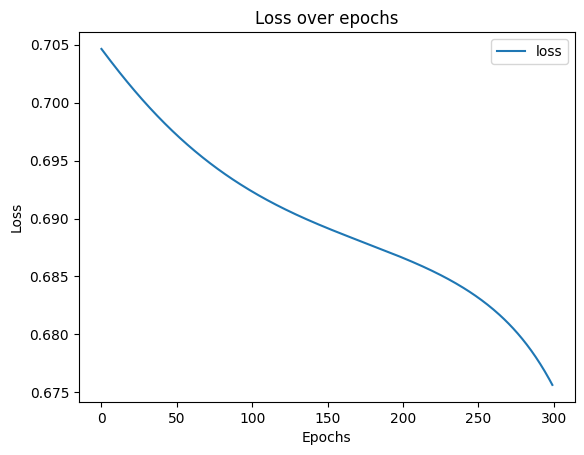

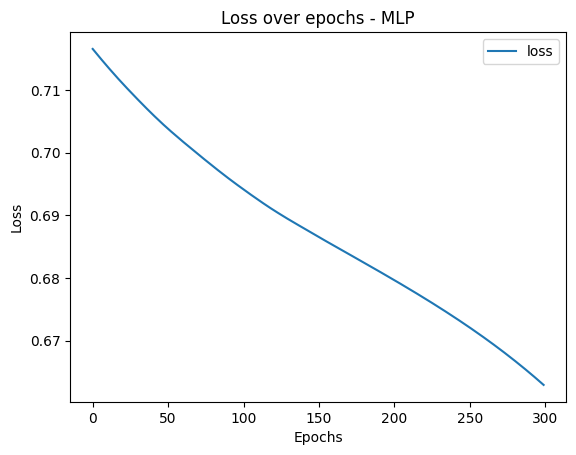

In [ ]:
plt.plot(losses_m3, label='loss')
plt.legend()
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
plt.plot(lossmlp, label='loss')
plt.legend()
plt.title('Loss over epochs - MLP')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Model 3 - only V2

In [ ]:
qrslead_v2 = data_df[['qrs_v2']].values
patient_ECG_qrs_v2 = qrslead_v2.tolist()
tensor_v2_qrs = torch.tensor(patient_ECG_qrs_v2).permute(0,2,1).float().to(device)

In [ ]:
lstmclassifier_m3_v2 = SequenceClassifier(input_size=1, hidden_size = 5,matrix=True).to(device)
mlp_m3_v2 = BMLP(input_size = 8, hidden_sizes = [10, 10]).to(device)

noptimizer_m3_v2 = torch.optim.Adam(lstmclassifier_m3_v2.parameters(), lr=5e-4)
noptimizer_m3_mlp_v2 = torch.optim.Adam(mlp_m3_v2.parameters(), lr=5e-4)

nloss_m3_seq_v2 = nn.BCELoss()
nloss_m3_mlp_v2 = nn.BCELoss()

losses_m3_v2, lossmlp_v2, points_v2, predictions_m3_v2 = train_seq_model3_2(tensor_v2_qrs, tags_tensor, xtrafeatures_tensor, lstmclassifier_m3_v2, mlp_m3_v2, noptimizer_m3_v2, noptimizer_m3_mlp_v2, nloss_m3_seq_v2, nloss_m3_mlp_v2, epochs=500)

--------Initializing training
training epoch #0
training epoch #5
training epoch #10
training epoch #15
training epoch #20
training epoch #25
training epoch #30
training epoch #35
training epoch #40
training epoch #45
training epoch #50
training epoch #55
training epoch #60
training epoch #65
training epoch #70
training epoch #75
training epoch #80
training epoch #85
training epoch #90
training epoch #95
training epoch #100
training epoch #105
training epoch #110
training epoch #115
training epoch #120
training epoch #125
training epoch #130
training epoch #135
training epoch #140
training epoch #145
training epoch #150
training epoch #155
training epoch #160
training epoch #165
training epoch #170
training epoch #175
training epoch #180
training epoch #185
training epoch #190
training epoch #195
training epoch #200
training epoch #205
training epoch #210
training epoch #215
training epoch #220
training epoch #225
training epoch #230
training epoch #235
training epoch #240
training epo

In [ ]:
test_sequence_classifier_in_test(np.asarray(tags_tensor.detach().cpu()), predictions_m3_v2, prob_threshold=0.5)

0.6886792182922363

# Model 3 - v2&3 + New patient feautes

In [ ]:
xtrafeatures_expanded = data_df[['Height','Weight', 'Age', 'Smoker', 'HTA', 'PVC_transition']]
mean_valuestest = xtrafeatures_expanded.mean(skipna=True)
xtrafeatures_expanded = xtrafeatures_expanded.fillna(mean_valuestest)
xtrafeatures_expanded = xtrafeatures_expanded[['Height','Weight', 'Age', 'Smoker', 'HTA', 'PVC_transition']].values
xtrafeatures_expanded = xtrafeatures_expanded.tolist()
xtrafeatures_expanded_tensor = torch.tensor(xtrafeatures_expanded).float().to(device)

In [ ]:
xtrafeatures_expanded_test = test_df[['Height','Weight', 'Age', 'Smoker', 'HTA', 'PVC_transition']]
mean_values_test = xtrafeatures_expanded_test.mean(skipna=True)
xtrafeatures_expanded_test = xtrafeatures_expanded_test.fillna(mean_values_test)
xtrafeatures_expanded_test = xtrafeatures_expanded_test[['Height','Weight', 'Age', 'Smoker', 'HTA', 'PVC_transition']].values
xtrafeatures_expanded_test = xtrafeatures_expanded_test.tolist()
xtrafeatures_expanded_tensor_test = torch.tensor(xtrafeatures_expanded_test).float().to(device)

In [ ]:
if 'lstmclassifier_m3_x' in globals():
  del lstmclassifier_m3_x
  print('Previous lstmclassifier_m3_x deleted')
if 'mlp_m3_x' in globals():
  del mlp_m3_x
  print('Previous mlp_m3_x deleted')


lstmclassifier_m3_x = SequenceClassifier(input_size=1, hidden_size = 10,matrix=True).to(device)
mlp_m3_x = BMLP(input_size = 16, hidden_sizes = [20, 5, 5]).to(device)

noptimizer_m3_x = torch.optim.Adam(lstmclassifier_m3_x.parameters(), lr=2e-4)
noptimizer_m3_mlp_x = torch.optim.Adam(mlp_m3_x.parameters(), lr=2e-4)

nloss_m3_seq_x = nn.BCELoss()
nloss_m3_mlp_x = nn.BCELoss()

losses_m3_x, lossmlp_v2_x, points_v2_x, predictions_m3_x, accuracies_m3_x, test_losses_m3_x, test_accuracies_m3_x, test_output_ms_x = train_seq_model3(leads_tensor_qrs_v2_v3, tags_tensor, xtrafeatures_expanded_tensor, leads_tensor_qrs_v2_v3_test, tags_tensor_test, xtrafeatures_expanded_tensor_test, lstmclassifier_m3_x, mlp_m3_x, noptimizer_m3_x, noptimizer_m3_mlp_x, nloss_m3_seq_x, nloss_m3_mlp_x, epochs=300)
#losses_m3_x, points_v2_v3_x, predictions_m3_x, accuracies_m3_x = train_seq_model3(leads_tensor_qrs_v2_v3, tags_tensor, xtrafeatures_expanded_tensor, lstmclassifier_m3_x, mlp_m3_x, noptimizer_m3_x, noptimizer_m3_mlp_x, nloss_m3_seq_x, nloss_m3_mlp_x, epochs=400)
points_array_m3 = np.asarray(points_v2_x.detach())

Previous lstmclassifier_m3_x deleted
Previous mlp_m3_x deleted
--------Initializing training
training epoch #0
training epoch #5
training epoch #10
training epoch #15
training epoch #20
training epoch #25
training epoch #30
training epoch #35
training epoch #40
training epoch #45
training epoch #50
training epoch #55
training epoch #60
training epoch #65
training epoch #70
training epoch #75
training epoch #80
training epoch #85
training epoch #90
training epoch #95
training epoch #100
training epoch #105
training epoch #110
training epoch #115
training epoch #120
training epoch #125
training epoch #130
training epoch #135
training epoch #140
training epoch #145
training epoch #150
training epoch #155
training epoch #160
training epoch #165
training epoch #170
training epoch #175
training epoch #180
training epoch #185
training epoch #190
training epoch #195
training epoch #200
training epoch #205
training epoch #210
training epoch #215
training epoch #220
training epoch #225
training 

<ipython-input-26-49e8a343d102>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output_tensor = torch.tensor(output)


training epoch #55
training epoch #60
training epoch #65
training epoch #70
training epoch #75
training epoch #80
training epoch #85
training epoch #90
training epoch #95
training epoch #100
training epoch #105
training epoch #110
training epoch #115
training epoch #120
training epoch #125
training epoch #130
training epoch #135
training epoch #140
training epoch #145
training epoch #150
training epoch #155
training epoch #160
training epoch #165
training epoch #170
training epoch #175
training epoch #180
training epoch #185
training epoch #190
training epoch #195
training epoch #200
training epoch #205
training epoch #210
training epoch #215
training epoch #220
training epoch #225
training epoch #230
training epoch #235
training epoch #240
training epoch #245
training epoch #250
training epoch #255
training epoch #260
training epoch #265
training epoch #270
training epoch #275
training epoch #280
training epoch #285
training epoch #290
training epoch #295


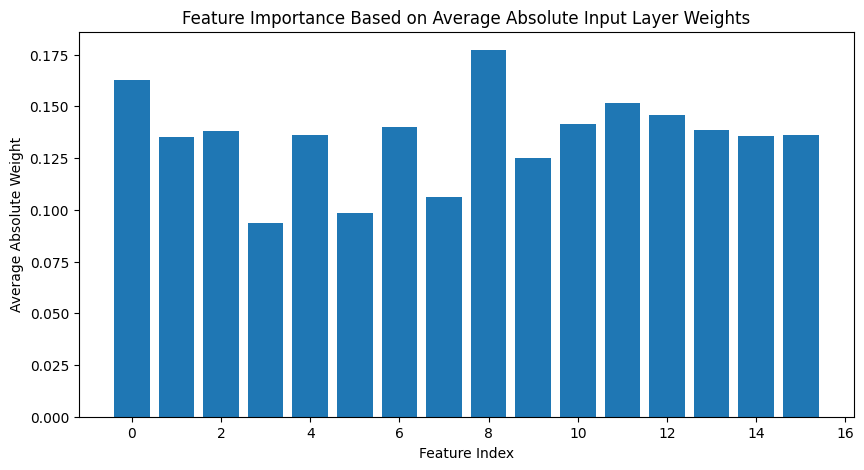

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def visualize_input_layer_weights(model):
    input_layer = model.network[0]
    # Ensure the weights are transferred to CPU before converting to NumPy
    weights = input_layer.weight.data.cpu().numpy()

    # Optional: Plot the average absolute weights across all neurons
    avg_weights = np.mean(np.abs(weights), axis=0)

    plt.figure(figsize=(10, 5))
    plt.bar(range(len(avg_weights)), avg_weights)
    plt.xlabel('Feature Index')
    plt.ylabel('Average Absolute Weight')
    plt.title('Feature Importance Based on Average Absolute Input Layer Weights')
    plt.show()

# Example: assuming mlp_m3_x is your trained model
visualize_input_layer_weights(mlp_m3_x)



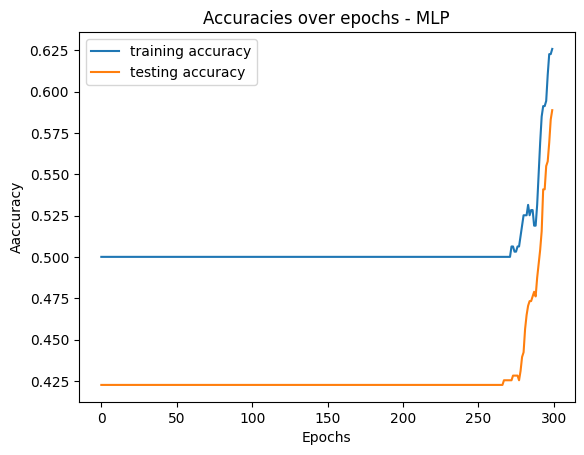

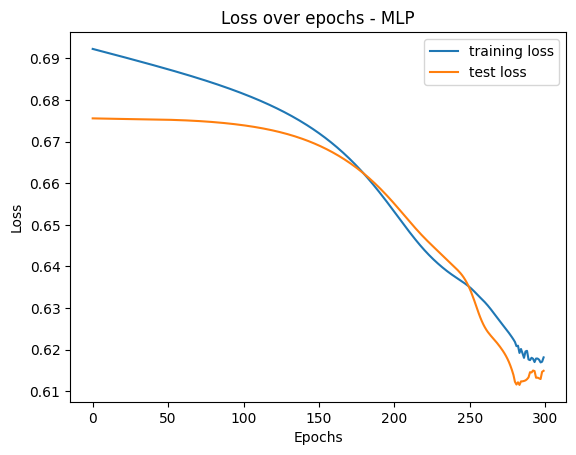

In [ ]:
plt.plot(accuracies_m3_x, label='training accuracy')
plt.plot(test_accuracies_m3_x, label='testing accuracy')
plt.legend()
plt.title('Accuracies over epochs - MLP')
plt.xlabel('Epochs')
plt.ylabel('Aaccuracy')
plt.show()
plt.plot(losses_m3_x, label='training loss')
plt.plot(test_losses_m3_x, label='test loss')
plt.legend()
plt.title('Loss over epochs - MLP')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
print(f'--> Final accuracy for training data:  {accuracies_m3_x[-1]}')
print(f'--> Final accuracy for testing data:   {test_accuracies_m3_x[-1]}')

--> Final accuracy for training data:  0.6257861852645874
--> Final accuracy for testing data:   0.5887324213981628


Balanced Training Data:
--> Out of [207] right samples, 159 were selected for training
--> Out of [159] right samples, 159 were selected for training


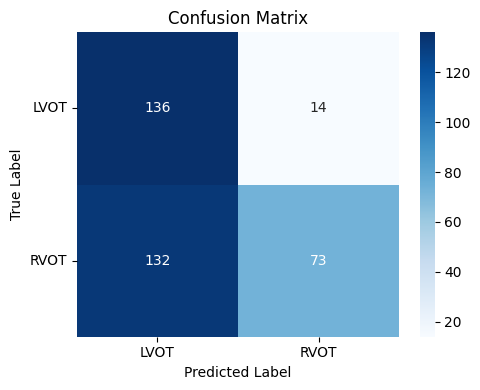

In [ ]:
output_array = (test_output_ms_x.squeeze(1) > 0.5).astype(int)
cm_m3_x = confusion_matrix( np.asarray(tags_tensor_test.cpu()).squeeze(1).astype(int), output_array)

print('Balanced Training Data:')
print(f'--> Out of [{right_size}] right samples, {nsamples} were selected for training')
print(f'--> Out of [{left_size}] right samples, {nsamples} were selected for training')

# print('\nTesting Data (different from training):')
# print(f'--> {r_test_size} Right samples were selected for testing')
# print(f'--> {l_test_size} Left samples were selected for testing')

# Class names
class_names = ['LVOT', 'RVOT']

# Plotting the heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm_m3_x, annot=True, fmt='d', cmap='Blues')

# Adding labels and title
plt.xticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names)
plt.yticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names, rotation=0)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Adjusting the layout for better fit
plt.tight_layout()

# Show the plot
plt.show()

# Model 3 - v2&3 + less patient features

In [ ]:
xtrafeatures_expanded_light = data_df[['Age', 'HTA', 'PVC_transition']]
mean_valuestest = xtrafeatures_expanded_light.mean(skipna=True)
xtrafeatures_expanded_light = xtrafeatures_expanded_light.fillna(mean_valuestest)
xtrafeatures_expanded_light = xtrafeatures_expanded_light[['Age', 'HTA', 'PVC_transition']].values
xtrafeatures_expanded_light = xtrafeatures_expanded_light.tolist()
xtrafeatures_expanded_light_tensor = torch.tensor(xtrafeatures_expanded_light).float().to(device)

In [ ]:
xtrafeatures_expanded_light_test = test_df[['Age', 'HTA', 'PVC_transition']]
mean_values_test = xtrafeatures_expanded_light_test.mean(skipna=True)
xtrafeatures_expanded_light_test = xtrafeatures_expanded_light_test.fillna(mean_valuestest)
xtrafeatures_expanded_light_test = xtrafeatures_expanded_light_test[['Age', 'HTA', 'PVC_transition']].values
xtrafeatures_expanded_light_test = xtrafeatures_expanded_light_test.tolist()
xtrafeatures_expanded_light_tensor_test = torch.tensor(xtrafeatures_expanded_light_test).float().to(device)

In [ ]:
lstmclassifier_m3_l = SequenceClassifier(input_size=1, hidden_size = 10,matrix=True).to(device)
mlp_m3_l = BMLP(input_size = 13, hidden_sizes = [11, 5, 5]).to(device)

noptimizer_m3_l = torch.optim.Adam(lstmclassifier_m3_l.parameters(), lr=3e-4)
noptimizer_m3_mlp_l = torch.optim.Adam(mlp_m3_l.parameters(), lr=3e-4)

nloss_m3_seq_l = nn.BCELoss()
nloss_m3_mlp_l = nn.BCELoss()

#losses_m3_1, _,points_v2_v3_1, predictions_m3_1, accuracies_m3_1, _, test_accuracies_m3_1  = train_seq_model3(leads_tensor_qrs_v2_v3, tags_tensor, xtrafeatures_tensor, leads_tensor_qrs_v2_v3_test, tags_tensor_test, xtrafeatures_tensor_test,lstmclassifier_m3_2, mlp_m3_2, noptimizer_m3_2, noptimizer_m3_mlp_2, nloss_m3_seq_2, nloss_m3_mlp_2, epochs=5)
losses_m3_l, lossmlp_m3_l, points_v2_v3_l, predictions_m3_l, accuracies_m3_l, test_losses_m3_l, test_accuracies_m3_l, test_output_ms_l = train_seq_model3(leads_tensor_qrs_v2_v3, tags_tensor, xtrafeatures_expanded_light_tensor, leads_tensor_qrs_v2_v3_test, tags_tensor_test, xtrafeatures_expanded_light_tensor_test, lstmclassifier_m3_l, mlp_m3_l, noptimizer_m3_l, noptimizer_m3_mlp_l, nloss_m3_seq_l, nloss_m3_mlp_l, epochs=300)
points_array_m3_l = np.asarray(points_v2_v3_l.detach())

--------Initializing training
training epoch #0
training epoch #5
training epoch #10
training epoch #15
training epoch #20
training epoch #25
training epoch #30
training epoch #35
training epoch #40
training epoch #45
training epoch #50
training epoch #55
training epoch #60
training epoch #65
training epoch #70
training epoch #75
training epoch #80
training epoch #85
training epoch #90
training epoch #95
training epoch #100
training epoch #105
training epoch #110
training epoch #115
training epoch #120
training epoch #125
training epoch #130
training epoch #135
training epoch #140
training epoch #145
training epoch #150
training epoch #155
training epoch #160
training epoch #165
training epoch #170
training epoch #175
training epoch #180
training epoch #185
training epoch #190
training epoch #195
training epoch #200
training epoch #205
training epoch #210
training epoch #215
training epoch #220
training epoch #225
training epoch #230
training epoch #235
training epoch #240
training epo

<ipython-input-26-49e8a343d102>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output_tensor = torch.tensor(output)


training epoch #70
training epoch #75
training epoch #80
training epoch #85
training epoch #90
training epoch #95
training epoch #100
training epoch #105
training epoch #110
training epoch #115
training epoch #120
training epoch #125
training epoch #130
training epoch #135
training epoch #140
training epoch #145
training epoch #150
training epoch #155
training epoch #160
training epoch #165
training epoch #170
training epoch #175
training epoch #180
training epoch #185
training epoch #190
training epoch #195
training epoch #200
training epoch #205
training epoch #210
training epoch #215
training epoch #220
training epoch #225
training epoch #230
training epoch #235
training epoch #240
training epoch #245
training epoch #250
training epoch #255
training epoch #260
training epoch #265
training epoch #270
training epoch #275
training epoch #280
training epoch #285
training epoch #290
training epoch #295


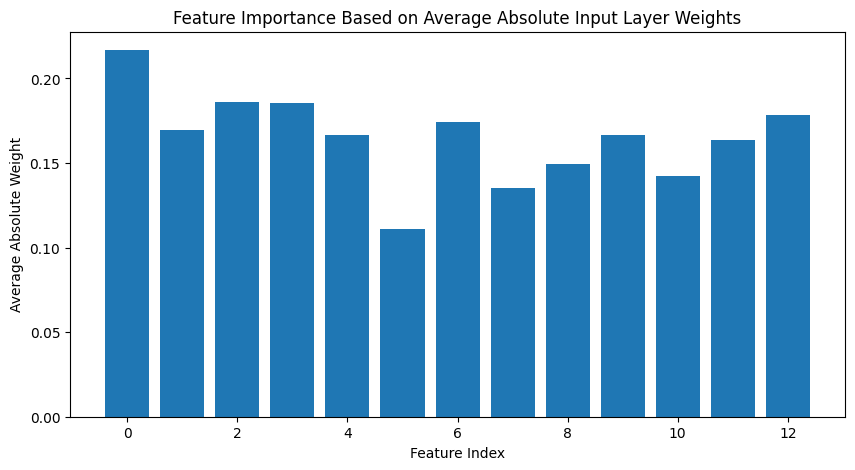

In [ ]:
visualize_input_layer_weights(mlp_m3_l)


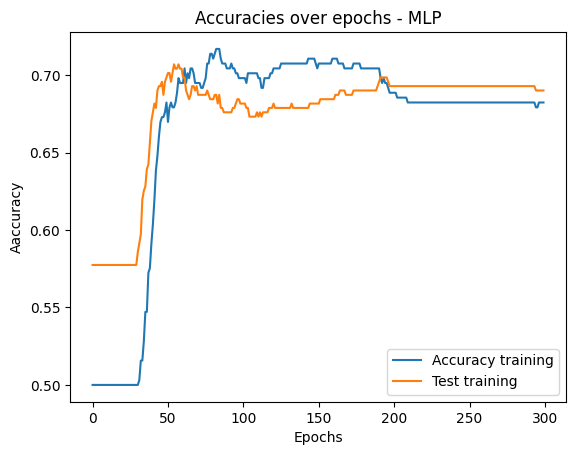

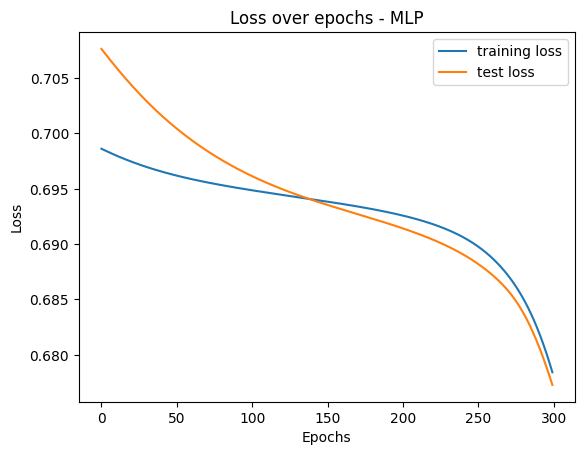

In [ ]:
plt.plot(accuracies_m3_l, label='Accuracy training')
plt.plot(test_accuracies_m3_l, label='Test training')
plt.legend()
plt.title('Accuracies over epochs - MLP')
plt.xlabel('Epochs')
plt.ylabel('Aaccuracy')
plt.show()
plt.plot(losses_m3_l, label='training loss')
plt.plot(test_losses_m3_l, label='test loss')
plt.legend()
plt.title('Loss over epochs - MLP')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
print(f'--> Final accuracy for training data:  {accuracies_m3_l[-1]}')
print(f'--> Final accuracy for testing data:   {test_accuracies_m3_l[-1]}')

--> Final accuracy for training data:  0.6823899149894714
--> Final accuracy for testing data:   0.6901408433914185


Balanced Training Data:
--> Out of [207] right samples, 149 were selected for training
--> Out of [159] right samples, 139 were selected for training


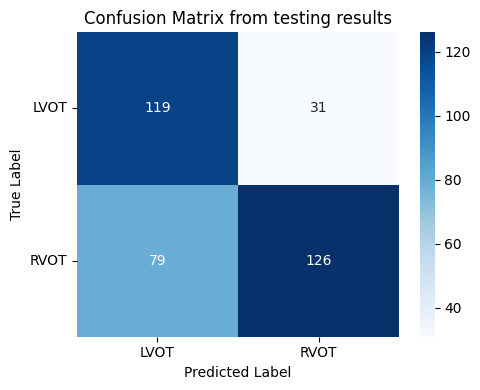

In [ ]:
output_array = (test_output_ms_l.squeeze(1) > 0.5).astype(int)
cm_m3_l = confusion_matrix(np.asarray(tags_tensor_test.cpu()).squeeze(1).astype(int), output_array)

print('Balanced Training Data:')
print(f'--> Out of [{right_size}] right samples, {nsamples-10} were selected for training')
print(f'--> Out of [{left_size}] right samples, {nsamples-20} were selected for training')

# print('\nTesting Data (different from training):')
# print(f'--> {r_test_size} Right samples were selected for testing')
# print(f'--> {l_test_size} Left samples were selected for testing')

# Class names
class_names = ['LVOT', 'RVOT']

# Plotting the heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm_m3_l, annot=True, fmt='d', cmap='Blues')

# Adding labels and title
plt.xticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names)
plt.yticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names, rotation=0)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix from testing results')

# Adjusting the layout for better fit
plt.tight_layout()

# Show the plot
plt.show()
